In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/clone_af_dendrograms'

In [2]:
INDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30"
OUTDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/barcodes/btwnClones_dendro_dt_dynamic_v02"
DONOR = 0

dendroThresh = "dynamic"

# INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
# DONOR = 1
#dendroThresh = "dynamic" #0.6

verbose=False

mt_ref="/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"

In [3]:
import src.utils.variant_utils as vu
import src.utils.dendro_clust as dc

import mplh.cluster_help as ch
import mplh.fig_utils as fu

from os.path import join, exists, dirname
from glob import glob
import pickle
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)
import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})
import scipy
from itertools import combinations
#from src.utils import utils  as ut

fig_utils from mplh
0.5.6


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
out_f = join(OUTDIR, f"donor{DONOR}")

### Load cells_meta 
### Create clones_meta - get number of cells in a clone and donor

In [6]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep="\t")
cells_meta["lineage"] = cells_meta.apply(lambda x: f'{x["donor"]}_{x["lineage"]}', axis=1)
cells_meta

,ID,lineage,donor,condition
0,AAACTGCAGACTTCCA-1_Input,0_0,0,Input
1,AAACTGCTCCAACGCG-1_Input,0_0,0,Input
2,AAAGGATCAGATAAGT-1_Input,0_0,0,Input
3,AAAGGATTCCTGACCT-1_Input,0_0,0,Input
4,AAAGGGCTCGTTACAG-1_Input,0_0,0,Input
...,...,...,...,...
6604,TAGGTGTGTACGTAAA-1_Input,1_25,1,Input
6605,TCCCACAGTTCAGAAA-1_Input,1_25,1,Input
6606,TCTCAGCCAGCAATGG-1_Input,1_25,1,Input
6607,TGGGTGCAGCGCCTAC-1_Input,1_25,1,Input


In [7]:
clones_meta_df = pd.DataFrame(cells_meta.groupby("lineage").size(), columns=["size"]) #, index=["size"])
clones_meta_df["donor"] = [x.split("_")[0] for x in clones_meta_df.index]
clones_meta_df["donor"] = clones_meta_df["donor"].astype(int)
clones_meta_df

,size,donor
lineage,,
0_0,447,0
0_1,279,0
0_10,106,0
0_11,105,0
0_12,104,0
...,...,...
1_5,165,1
1_6,159,1
1_7,142,1


In [8]:
curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR]
# cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t')#.sort_values(["donor", "lineage"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]

In [9]:
# curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR].set_index("lineage")
# curr_clones

## Load AF and DP

In [10]:
af_indir = join(INDIR, "sc_af", f"donor{DONOR}")
AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")


### Functions to get mean and median

In [11]:
def calc_mean(cells, af, min_cov=2):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].mean(axis=1)

def calc_median(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].median(axis=1)


def calc_mean_with_coverage(cells, af, cov, min_cov=200):
    keep_inds = cov.loc[:, cells["ID"].values]
    print(keep_inds.head())
    keep_inds = keep_inds[keep_inds >= min_cov].columns
    
    print('keep_inds', len(cells["ID"].values)- len(keep_inds))
    return af.loc[:,keep_inds].mean(axis=1)

### Calculate clone-barcode mean

In [12]:
mean_af = curr_labels.groupby(["lineage"]).apply(calc_mean, af=AF_df)

mean_nocov_af = curr_labels.groupby(["lineage"]).apply(calc_mean_with_coverage, af=AF_df, cov=DP_df)

         AAACTGCAGACTTCCA-1_Input  AAACTGCTCCAACGCG-1_Input  \
Variant                                                       
146A                           35                        78   
709A                           33                       111   
930A                           51                       164   
1413A                          62                       172   
1888A                          37                       135   

         AAAGGATCAGATAAGT-1_Input  AAAGGATTCCTGACCT-1_Input  \
Variant                                                       
146A                           81                        60   
709A                          147                       107   
930A                          197                       115   
1413A                         183                       141   
1888A                         184                       132   

         AAAGGGCTCGTTACAG-1_Input  AAATGAGGTTGTGAGG-1_Input  \
Variant                                              

keep_inds 0
         AAACTGCCATCCGTGG-1_Input  AACAGTCTCGAGAACG-1_Input  \
Variant                                                       
146A                           16                        46   
709A                           28                        97   
930A                           49                        93   
1413A                          83                       126   
1888A                          61                       159   

         AACGGGAAGGGTATCG-1_Input  AACGGGATCGCGCCAA-1_Input  \
Variant                                                       
146A                           37                        46   
709A                          143                        93   
930A                           62                       102   
1413A                         146                       128   
1888A                          95                        82   

         AACTGGTAGAGCCACA-1_Input  AACTGGTGTAGAGAGA-1_Input  \
Variant                                  

In [13]:

anno = mean_af.reset_index()[["lineage"]]

# Remove clones that have all 0
# print('mean_af shape', mean_af.shape)
# mean_af = mean_af.loc[~((mean_af==0).all(axis=1))]
# curr_clones = curr_clones.loc[mean_af.index]
# print('mean_af shape after rm 0', mean_af.shape)

mean_dp = curr_labels.groupby(["lineage"]).apply(calc_mean, af=np.log2(DP_df+1))
mean_dp = mean_dp.loc[mean_af.index, mean_af.columns]

#mean_dp = mean_dp.reset_index(drop=True)
anno_dp = mean_dp.reset_index()[["lineage"]]
na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

if not (na_mean_af.shape[0] == 0):
    print('na shape', na_mean_af.shape)
    na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_mean_af.index)})), ignore_index=True)
    na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)
    na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
    na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)
else:
    na_anno = anno
    na_concat = mean_af.reset_index(drop=True)
    na_dp_concat = mean_dp
    
print((mean_af<0.01).all(axis=0).sum())

print((mean_af<0.01).all(axis=1).sum())

# rm low mean af barcodes
mean_af = mean_af.loc[:,~(mean_af<0.01).all(axis=0)]
mean_af  

30
0


Variant,1888A,1949A,2514A,3242A,3244A,3820A,4837A,5147A,7775A,8697A,...,5581G,10559G,13676G,14233G,15244G,3735T,7361T,12283T,16294T,16296T
lineage,,,,,,,,,,,,,,,,,,,,,
0_0,0.004577,0.000618,0.004234,0.005276,0.000487,0.000470,0.003391,0.001214,0.003618,0.006483,...,0.932052,0.008033,0.000068,0.000965,0.004759,0.003447,0.003110,0.002216,0.000995,0.000324
0_1,0.000148,0.000472,0.000000,0.000082,0.000340,0.000551,0.000053,0.000395,0.000080,0.000745,...,0.000238,0.000087,0.001816,0.000401,0.000600,0.000172,0.000129,0.000500,0.000234,0.000181
0_10,0.001198,0.002033,0.001163,0.000074,0.008205,0.001005,0.002065,0.000462,0.000611,0.001098,...,0.667069,0.002181,0.000396,0.000448,0.004586,0.001137,0.002125,0.000818,0.000000,0.000248
0_11,0.000220,0.002717,0.000858,0.000102,0.000140,0.003621,0.001126,0.002192,0.000511,0.000810,...,0.000756,0.000405,0.000340,0.001718,0.000984,0.000984,0.001027,0.013708,0.000235,0.000235
0_12,0.003174,0.279984,0.001624,0.000000,0.000125,0.001263,0.002045,0.003324,0.002186,0.003014,...,0.773325,0.003887,0.005409,0.002015,0.000000,0.002539,0.002412,0.002388,0.001872,0.002180
0_13,0.001755,0.001019,0.001379,0.000000,0.000000,0.004623,0.001401,0.003119,0.000659,0.034076,...,0.002653,0.001601,0.000147,0.000703,0.001944,0.000538,0.002017,0.001781,0.000250,0.000253
0_14,0.000962,0.001489,0.000734,0.000638,0.000000,0.001068,0.002681,0.001900,0.002835,0.001596,...,0.939894,0.000604,0.001308,0.002470,0.000000,0.000816,0.001745,0.001789,0.000592,0.000615
0_15,0.000580,0.017700,0.000872,0.010217,0.000440,0.001827,0.014508,0.002494,0.000165,0.001475,...,0.001722,0.000862,0.000624,0.002716,0.000193,0.000208,0.001172,0.001018,0.000210,0.000213
0_16,0.003232,0.002667,0.000970,0.006349,0.006848,0.001497,0.000988,0.003136,0.000323,0.002251,...,0.000850,0.001266,0.000301,0.002499,0.000638,0.001715,0.001258,0.001022,0.000000,0.000000


In [14]:
# Get variant types
variants_df = vu.add_ref_to_variants(variants=mean_af.columns.values,
                                     mt_df=vu.load_mt_ref(mt_ref))

variants_df = vu.type_of_variants(variants_df, to_preproc=False)

In [15]:
# mean_af.to_csv(out_f+".initInds.mean.csv")

# curr_clones[["donor","size", "log2_fold","-log10(fold p_adj)", "shuffle_sig", 
#              "ncells"]+ list(curr_labels["condition"].unique())].to_csv(out_f+".initInds.indsMeta.csv")

### Cluster to get dendro results

In [16]:

if mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 :
    print('no clustering needed only one var')
else:
    g = sns.clustermap(mean_af, row_cluster=True, col_cluster=True, vmax=0.2, vmin=0)
    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]
    curr_clones = curr_clones.iloc[inds]
    plt.close(g.fig)

### Cluster and calculate proper size

In [17]:
%matplotlib inline
if not (mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 ):
    
    if dendroThresh == "dynamic":
        clusters, link = dc.run_dynamic_hyper(np.sqrt(mean_af))
        #clusters, link = dc.run_dynamic(mean_af, metric='euclidean', method="average", minClusterSize=1)
        curr_clones["den_clust"] = curr_clones.apply(lambda x: f'C{clusters.loc[x.name, "labels"]}', axis=1)
    else:
        den = dc.dendro_cluster(mean_af, g, d_thresh=dendroThresh)

        if verbose:
            print('icoord and color list')
            print(len(den["icoord"]))
            print(len(den["color_list"]))
            print('leaves leaves color and mean_af shape')
            print(len(den["leaves"]))
            print(len(den["leaves_color_list"]))
            print(mean_af.shape)
        # cluster_classes = dc.get_cluster_classes(den)
        curr_clones = dc.add_cluster_labels(den,curr_clones)
        curr_clones

    size_pvals = dc.cluster_stats(curr_clones, out_f= out_f )

    curr_clones["donor"]= [x.split("_")[0] for x in curr_clones.index]
    curr_clones = curr_clones.loc[mean_af.index]

    # with open(out_f + ".dendrogram_pvals.txt", "w") as f:
    #     #for l in size_pvals:
    #     f.write("\n".join(size_pvals))
else:
    with open(out_f+".dendrogram_pvals.txt", "w") as f:
        f.write("no cells")
    

distances
[0.29642 0.01671 0.28330 0.07523 0.26741 0.01651 0.27607 0.27916 0.43225
 0.30371 0.28951 0.02523 0.39250 0.28410 0.02000 0.06405 0.01949 0.28643
 0.28016 0.28477 0.02156 0.30286 0.01436 0.02085 0.30617 0.30430 0.17552
 0.41787 0.43906 0.01452 0.27059 0.28180 0.09171 0.26600 0.27408 0.23704
 0.03166 0.30710 0.05225 0.29859 0.03872 0.04592 0.26993 0.09258 0.02597
 0.17031 0.27758 0.06911 0.30099 0.35067 0.29426 0.04013 0.02982 0.03221
 0.30108 0.03372 0.28551 0.29913 0.12513 0.04756 0.38992 0.26436 0.21648
 0.30722 0.03770 0.03318 0.08470 0.04268 0.02553 0.23248 0.07217 0.23710
 0.01973 0.23125 0.23725 0.39041 0.25985 0.23710 0.02065 0.41367 0.24280
 0.02610 0.07479 0.01962 0.24621 0.22857 0.24125 0.02659 0.25320 0.01410
 0.02593 0.29572 0.26351 0.17809 0.40825 0.40888 0.01508 0.23105 0.23863
 0.07461 0.23228 0.23440 0.29187 0.05511 0.29243 0.04798 0.05050 0.24734
 0.09727 0.03207 0.17156 0.26358 0.06699 0.29469 0.33384 0.28981 0.05445
 0.04923 0.04035 0.29579 0.04698 0.29275 

## Group clones using dendrogram and run stats on size differences in the groups

### Run ranksums on clone size btwn debdrogram clusters

In [18]:
# size_pvals = []
# for pair in combinations(curr_clones["den_clust"].unique(),2):
#     print(pair)
#     stat, p_val = scipy.stats.ranksums(curr_clones.loc[curr_clones["den_clust"]==pair[0], "size"].values, 
#                          y=curr_clones.loc[curr_clones["den_clust"]==pair[1], "size"].values, 
#                          alternative='two-sided')

#     size_pvals.append(f"{pair[0]}, {pair[1]}, {str(p_val)}")
    


## Plot with dendro clusters

In [19]:
conditions = cells_meta["condition"].unique()

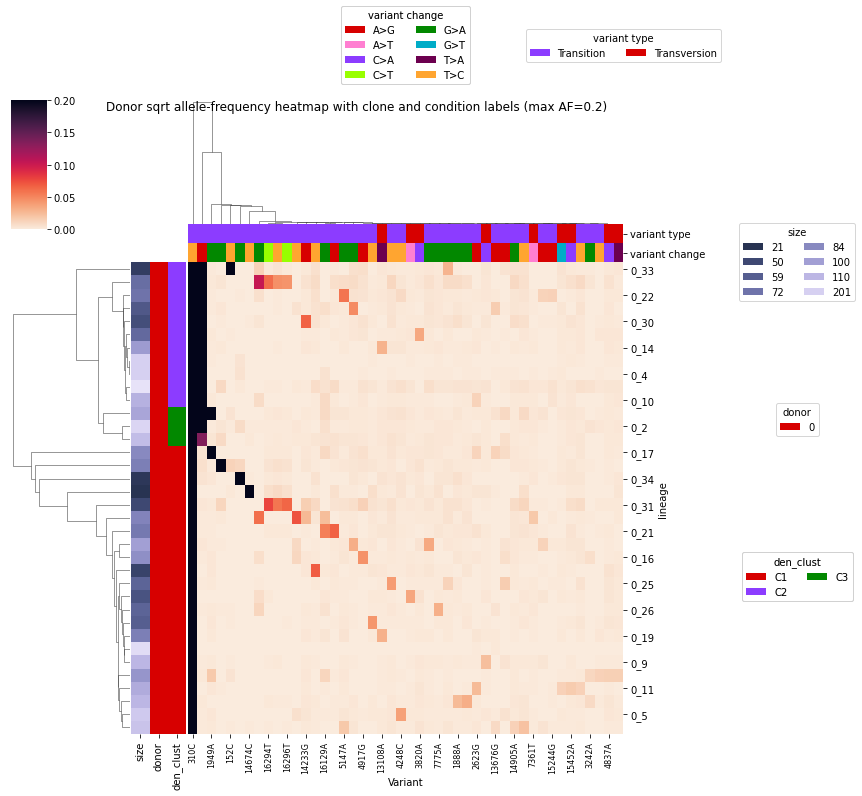

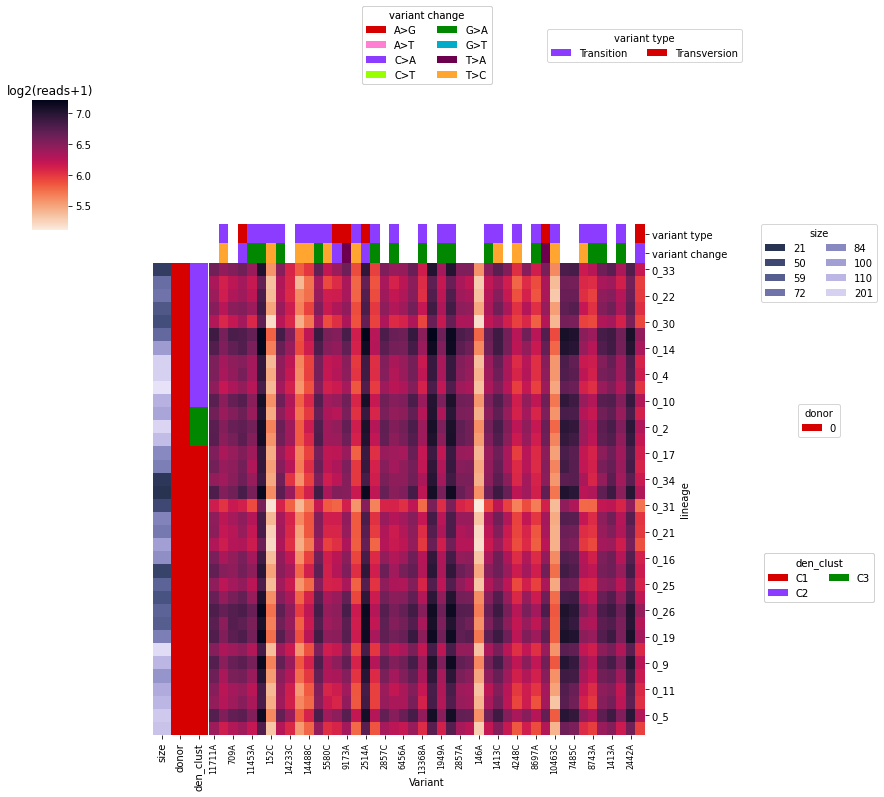

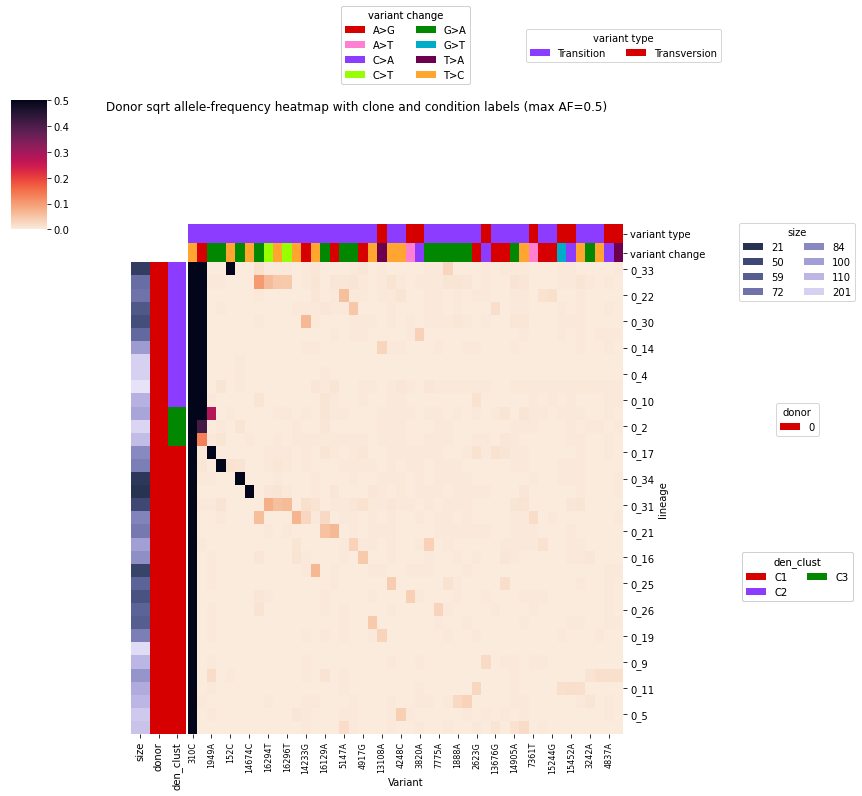

In [20]:
if not (mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 ):
    g = ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=True, to_col_clust=True,
                        col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                        row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                        vmax=0.2, vmin=0, cmap="rocket_r",
                        row_linkage=link)
    plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.2)")
    #fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max2.AF.png",to_pdf=False)
    fu.helper_save(out_f+".dendro.NoCondition.max2.AF.png",to_pdf=True, to_svg=True)

    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]

    g1d = ch.plot_cluster(mean_dp.iloc[inds, cols], row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                          row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                          col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                          cmap="rocket_r"
                         )
    g1d.ax_cbar.set_title("log2(reads+1)")
    fu.helper_save(out_f+".dendro.NoCondition.DP.png",to_pdf=True, to_svg=True)#, f=g1d.figure)


    mean_af = mean_af.iloc[inds,cols]
    curr_clones = curr_clones.loc[mean_af.index]

    ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                    col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                    row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                    vmax=0.5, vmin=0, cmap="rocket_r")
    plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
    #fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max5.AF.png",to_pdf=False)
    fu.helper_save(out_f+".dendro.NoCondition.max5.AF.png",to_pdf=True, to_svg=True)

else:
    f = plt.figure()
    plt.title("no cells")
    f.savefig(out_f+".dendro.NoCondition.max2.AF.png")


In [21]:
# ## Get top3 variants for each clone and plot af

# def get_max_diff(clone, af):
#     print(clone.name)
#     return (af.loc[clone.name]-af).sum()

# max_diffs = mean_af.apply(get_max_diff, args=(mean_af,),axis=1)
# max_diffs

### Save mean_af and curr_clonnes

In [22]:

mean_af.to_csv(out_f+".mean.csv")
curr_clones.to_csv(out_f+".clones_dendro.csv")